# Fast and furious growth

The following code is linked to the analysis of the article *‘Direct Evidence of Apex–Hypha Interactions During Vegetative Growth of Fungal Thallus via Comprehensive Network and Trajectory Extraction’*.
Its purpose is to highlight the interactions that can exist between apices and hyphae. 
Here we look at the effect of the proximity of a hypha on the growth rate of an apex, both in terms of norm and orientation.

In [2]:
#The usual suspects
import matplotlib.pyplot as plt #To make figure
plt.rcParams.update({'font.size':12})#To make figure readable
import numpy as np #For everything

from tqdm import tqdm #For nice loading bars
from scipy import stats
from scipy.stats import norm # For normal law

from pickle import load as pload


from Reseau import Reseau,Branche 


frame2h = 18/60
pixel2micro = 1.6
radius_of_vision = 180/pixel2micro
angle_of_vision = np.pi/2
tmax = 10#h

FOLDER = "./Experiments"

experiments = {
    name:
    {
        "output_dir":f"{FOLDER}/"
    }
    for name in [
        "M2WT_200610",
        "M2WT_200616",
        "M2WT_200617",
        "M2WT_210304",
        "M2WT_210909"
        ]
}

def load(name:str)->Reseau:
    """
    Load the data from the selected experiment into a Reseau object
    """
    params = experiments[name]
    pathToFile = params["output_dir"]+name+"_ready.gpickle"
    with open(pathToFile,"rb") as f:
        reseau = pload(f)
    return reseau


M2s:list[Reseau] = [load(name)
                    for name in tqdm(
                        experiments.keys(),
                        desc ="Network loading ... ")]



Network loading ... : 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


# Data extraction

In [3]:
def filtre_branches_apicales(r:Reseau,radius_of_vision:float=100,angle_of_vision:float=np.pi/2)->tuple[list[Branche]]:
    """
    Given a reseau 'r' return the list of apical branches that
    are not obstructed and the list of apical branches that are obstructed
    """
    branches_apicales = [b for b in r.branches 
                         if (b.nature == "Apical")]# and (r.g.degree(b.noeuds[-1])!=3) and (np.all(np.array(b.noeuds)>0))]
    r2 = radius_of_vision*radius_of_vision
    demi_angle = angle_of_vision/2
    free = []
    obstructed = []
    pos = np.array([[r.n2x[n],r.n2y[n]] for n in r.g.nodes])
    times = np.array([r.n2t[n] for n in r.g.nodes])
    for b in tqdm(branches_apicales):
        test = True
        for apex in b.apex():
            t = r.n2t[apex]
            posa = np.array([r.n2x[apex],r.n2y[apex]])
            f = np.where(times<=t)
            dist2 = np.where(times<=t,np.sum((pos-posa)*(pos-posa),axis=1),-1)
            pot = pos[np.where(np.logical_and(dist2>0,dist2<=r2))]-posa
            tangent = b.tangent(apex)
            angles = np.arctan2(pot[:,1],pot[:,0])-np.arctan2(tangent[1],tangent[0])
            test = test and np.all(np.abs(angles)>demi_angle)
            if not test:
                break
        category = free if test else obstructed
        category.append(b)
    return free,obstructed

branches = {}
for r in tqdm(M2s,desc="Selection of free branches ... "):
    r.classification_nature_branches(threshold=5)
    branches[r.name] = filtre_branches_apicales(r,radius_of_vision=radius_of_vision,angle_of_vision=np.pi/2)































































































100%|██████████| 1544/1544 [00:12<00:00, 120.42it/s]










































100%|██████████| 903/903 [00:05<00:00, 156.15it/s]






































































































































































































100%|██████████| 2906/2906 [00:27<00:00, 106.17it/s]




















































100%|██████████| 1128/1128 [00:07<00:00, 157.38it/s]




/Users/thibault/Documents/GitHub/HyphalNetwork_ApexHypha_Interactions/Reseau.py:436: RuntimeWarning: invalid value encountered in true_divide
  direction = np.array([dx,dy])/np.sqrt(dx*dx+dy*dy)













Selection of free branches ... : 100%|██████████| 5/5 [00:56<00:00, 11.38s/it]


In [4]:
def branches2growthdata(r:Reseau,branches:list[Branche])->np.ndarray:
    """
    Return data about the specified branches in the reseau r
    The format is: t,v,dvdt,dthetadt,branch_index
        t is in h
        v is in µm/h
        dvdt is in µm/h^2
        dthetadt is in rad/h
    """
    data = []
    for b in branches:
        times,speeds = b.vecteurs_vitesses()
        if len(times)>3:
            times = (times - b.get_tstart())*frame2h
            normes = np.linalg.norm(speeds,axis=1)*pixel2micro/frame2h
            angles = np.unwrap(np.arctan2(speeds[:,1],speeds[:,0]))
            dt = times[2:]-times[:-2]
            dthetadt = np.where(dt>0,(angles[2:]-angles[:-2])/(times[2:]-times[:-2]),0)

            dvdt = np.where(dt>0,(normes[2:]-normes[:-2])/(times[2:]-times[:-2]),0)
            bi = b.index*np.ones_like(dvdt)
            data.append(zip(times[1:-1],normes[1:-1],dvdt,dthetadt,bi))
    data = np.array([[*elem] for sublist in data for elem in sublist])
    return data

datas = {r.name:branches2growthdata(r,branches[r.name][0]) 
         for r in tqdm(M2s,desc="Measurement of branch growth rates ... ")}


Measurement of branch growth rates ... : 100%|██████████| 5/5 [00:00<00:00, 25.03it/s]


In [5]:
def filtre_data(datas:np.ndarray,tmax:float=10,vmax:float=1000)->np.ndarray:
    t = datas[:,0]
    v = datas[:,1]
    f = np.where(np.logical_and(t<tmax,v<=vmax))
    datas_f = datas[f,:][0]
    return datas_f

datas_f = {r.name:filtre_data(datas[r.name],tmax=tmax,vmax=1000) 
           for r in tqdm(M2s,desc="Filtering spurious points ... ")}


Filtering spurious points ... : 100%|██████████| 5/5 [00:00<00:00, 8240.28it/s]


In [6]:
def data2fit(datas:np.ndarray):
    t = datas[:,0]
    v = datas[:,1]
    dvdt = datas[:,2]
    dthetadt = datas[:,3]
    sigma = np.sqrt(np.mean(v*v*dthetadt*dthetadt))
    #A = np.mean(v*v)-np.mean(v)**2
    #B = 2*(np.mean(v*dvdt)-np.mean(v)*np.mean(dvdt))
    #C = np.mean(dvdt*dvdt)-np.mean(dvdt)**2-np.mean(v*v*dthetadt*dthetadt)
    #Delta = B*B-4*A*C
    gamma= np.sqrt(np.abs(np.mean(v*v*dthetadt*dthetadt)-np.var(dvdt))/np.var(v))#(-B+np.sqrt(Delta))/(2*A)
    vinf= np.mean(dvdt)/gamma+np.mean(v)
    sigma = np.sqrt(np.mean(v*v*dthetadt*dthetadt))
    return gamma,vinf,sigma

fit = {r.name:data2fit(datas_f[r.name]) 
       for r in tqdm(M2s,desc="Calculation of model adjustments ... ")}


Calculation of model adjustments ... : 100%|██████████| 5/5 [00:00<00:00, 2932.26it/s]


In [7]:
def error_estimation_bootstrap(datas:np.ndarray,Ntest:int):
    """ 
    Return the numerical estimation of model parameters gamma, vinf and sigma 
    via bootstrap.
    """
    results = []
    Nrows,Ncols = datas.shape
    index = np.arange(Nrows)
    for i in range(Ntest):
        bootstrap_index = np.random.choice(index,size=Nrows)
        data_reechantillonnee = datas[bootstrap_index,:]
        results.append(data2fit(data_reechantillonnee))
    results = np.array(results)
    means = np.mean(results,axis=0)
    covar = np.array([[np.mean((results[:,i]-means[i])*(results[:,j]-means[j])) for j in range(3)] for i in range(3)])
    return means,covar

fit_witherror = {r.name:error_estimation_bootstrap(datas_f[r.name],Ntest=1000)
                 for r in tqdm(M2s)}

100%|██████████| 5/5 [00:00<00:00,  9.46it/s]


# Fig 1: elongation speed

[  1.79415103 306.53683435 142.65145389]


/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/4267400912.py:6: RuntimeWarning: invalid value encountered in true_divide
  dv2_v2 = covar[0,0]*t*t*np.exp(-2*gamma*t)/((1-np.exp(-gamma*t))*(1-np.exp(-gamma*t)))
/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/4267400912.py:8: RuntimeWarning: invalid value encountered in true_divide
  dv2_v2 += covar[0,1]*t*np.exp(-gamma*t)/v
/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/4267400912.py:6: RuntimeWarning: invalid value encountered in true_divide
  dv2_v2 = covar[0,0]*t*t*np.exp(-2*gamma*t)/((1-np.exp(-gamma*t))*(1-np.exp(-gamma*t)))
/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/4267400912.py:8: RuntimeWarning: invalid value encountered in true_divide
  dv2_v2 += covar[0,1]*t*np.exp(-gamma*t)/v


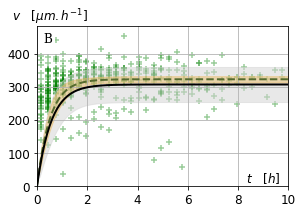

In [11]:
def v_fit(t:float,gamma:float,vinf:float)->float:
    return vinf*(1-np.exp(-gamma*t))

def dv_fit(t:float,gamma:float,vinf:float,covar:np.ndarray)->float:
    v = v_fit(t,gamma,vinf)
    dv2_v2 = covar[0,0]*t*t*np.exp(-2*gamma*t)/((1-np.exp(-gamma*t))*(1-np.exp(-gamma*t)))
    dv2_v2 += covar[1,1]/(vinf*vinf)
    dv2_v2 += covar[0,1]*t*np.exp(-gamma*t)/v
    dv = v*np.sqrt(dv2_v2)
    return dv
r_exemple = M2s[1]
w = 150
fig_1,axes_1 = plt.subplot_mosaic([[".","v_vs_t","v_vs_t"],
                                   [".","v_vs_t","v_vs_t"]],
                                   figsize=(6,3),layout="tight")
"""
============================================================================
                                    v_vs_t
============================================================================
"""
data_exemple = datas_f[r_exemple.name]
(gamma,vinf,sigma),covar = fit_witherror[r_exemple.name]
ax = axes_1["v_vs_t"]
ax.set_xlabel("$t\quad [h]$")
ax.xaxis.set_label_coords(0.9,0.1)
ax.set_ylabel("$v\quad [\mu m.h^{-1}]$",rotation="horizontal")
ax.yaxis.set_label_coords(0.05,1)
ax.set_xlim(0,tmax)
ax.set_ylim(0,1.5*vinf)
residues = data_exemple[:,1]-v_fit(data_exemple[:,0],gamma=gamma,vinf=vinf)
mean,ecarttype = np.mean(residues),np.std(residues)
ax.annotate(
        "B",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0))
ax.scatter(data_exemple[:,0],data_exemple[:,1],alpha=.4,marker="+",color="green")
t_fit = np.linspace(0,10,101)
vs = v_fit(t_fit,gamma,vinf)
dvs = dv_fit(t_fit,gamma,vinf,covar[:2,:2])
ax.plot(t_fit,vs,color="darkolivegreen",ls='--',lw=2)
ax.fill_between(t_fit,vs+3*dvs,vs-3*dvs,color="orange",alpha=.5)
global_means = np.mean([fit[r.name] for r in M2s],axis=0)
print(global_means)
gamma_glob,vinf_glob,sigma_glob = global_means
global_stds = np.std([fit[r.name] for r in M2s ],axis=0)
vs_glob = v_fit(t_fit,gamma_glob,vinf_glob)
dvs_glob = dv_fit(t_fit,gamma_glob,vinf_glob,np.array([[global_stds[0]*global_stds[0],0],[0,global_stds[1]*global_stds[1]]]))
ax.plot(t_fit,vs_glob,"k-",lw=2)
ax.fill_between(t_fit,vs_glob+3*dvs_glob,vs_glob-3*dvs_glob,color="lightgrey",alpha=.5)
ax.grid()
plt.show()

# Fig 2: noise estimation

In [12]:
def eta(datas:np.ndarray,gamma:float,vinf:float)->np.ndarray:
    """ 
    Given a collection of data is the format:
        col 0: t
        col 1: v
        col 2: dv/dt
        col 3: dtheta/dt
        col 4: branch_index
    return the estimation of eta-v and eta_theta according to our model:
        eta_v = dv/dt - gamma*(v_inf-v)
        eta_theta = v*dtheta/dt
    """
    eta_v = datas[:,2]-gamma*(vinf-datas[:,1])
    eta_theta = datas[:,1]*datas[:,3]
    return np.vstack((eta_v,eta_theta))

etas = {r.name:eta(datas_f[r.name],fit[r.name][0],fit[r.name][1]) for r in M2s if r.name != "M2WT_210908"}
etas_obstr = {r.name:eta(filtre_data(branches2growthdata(r,branches[r.name][1])),
                         fit[r.name][0],fit[r.name][1])
              for r in M2s}

/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:18: RuntimeWarning: divide by zero encountered in true_divide
  dthetadt = np.where(dt>0,(angles[2:]-angles[:-2])/(times[2:]-times[:-2]),0)
/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:20: RuntimeWarning: divide by zero encountered in true_divide
  dvdt = np.where(dt>0,(normes[2:]-normes[:-2])/(times[2:]-times[:-2]),0)


In [13]:
def scatter_hist(x, y, ax, ax_histx, ax_histy,bins,color,cmap:str="")->None:
    ax.sharex(ax_histx)
    ax.sharey(ax_histy)
    bins_x,bins_y = bins
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    ax.hist2d(x, y,bins=(bins_x,bins_y),cmap=cmap)#,color=color,alpha=.4)
    # now determine nice limits by hand:
    ax_histx.hist(x, bins=bins_x,density=True,color=color,histtype="stepfilled")
    ax_histx.set_ylabel("$pdf$",rotation = "horizontal")
    ax_histx.yaxis.set_label_coords(0.08,0.65)
    ax_histy.hist(y, bins=bins_y, orientation='horizontal',density=True,color=color,histtype="stepfilled")
    ax_histy.set_xlabel("$pdf$")
    ax_histy.xaxis.set_label_coords(0.65,0.08)
    return

Network loading ... :   0%|          | 0/5 [03:30<?, ?it/s]


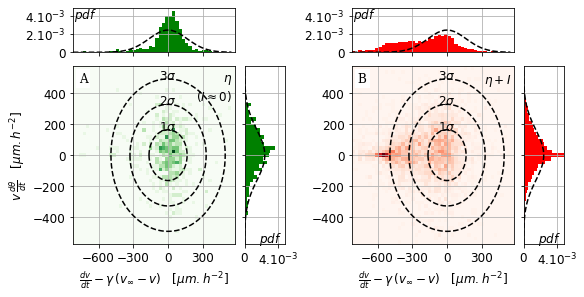

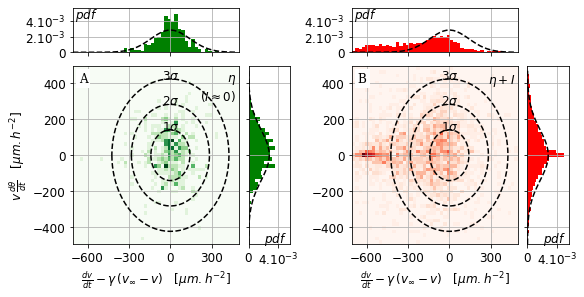

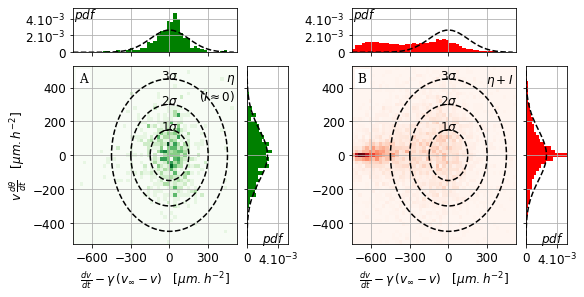

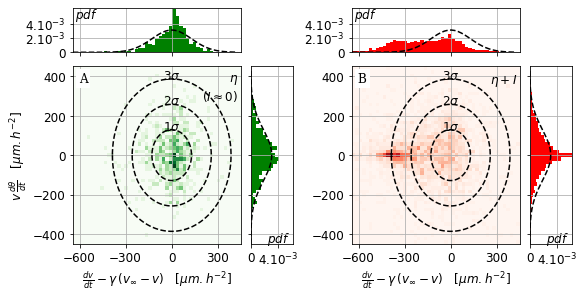

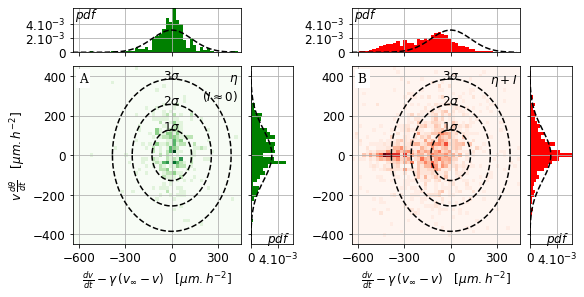

In [14]:
for rname,eta_free in etas.items():
    eta_ob = etas_obstr[rname]
    Npts = np.sum(np.logical_and(np.abs(eta_free[0,:])<4*sigma,
                                 np.abs(eta_free[1,:])<4*sigma))
    gamma,vinf,sigma = fit[rname]
    thetas = np.linspace(-np.pi,np.pi,360)
    fig_2, axs = plt.subplot_mosaic([['histx', '.','histx2','.'],
                                   ['scatter', 'histy','scatter2','histy2']],
                                figsize=(8,4),
                                gridspec_kw={'width_ratios':[4,1,4,1], 'height_ratios':[1,4]},
                                layout='constrained')
    axs["histy"].sharey(axs["scatter2"])
    bins_x = np.linspace(-5,3.5,50)*sigma
    bins_y = np.linspace(-3.5,3.5,50)*sigma
    bins= (bins_x,bins_y)
    #bins = 5*sigma*np.linspace(-1,1,50)
    scatter_hist(eta_free[0,:],eta_free[1,:],axs['scatter'],axs["histx"],axs['histy'],
                 bins=bins,color="green",cmap="Greens")
    scatter_hist(eta_ob[0,:],eta_ob[1,:],axs['scatter2'],axs["histx2"],axs['histy2'],
                 bins=bins,color="red",cmap="Reds")
    #scatter_hist(eta_ob[0,:],eta_ob[1,:],axs['scatter'],axs["histx"],axs['histy'],
    #             bins=bins,color="red")
    
    for ax in (axs["scatter"],axs["scatter2"]):
        for i in range(1,4):
            ax.plot(i*sigma*np.cos(thetas),i*sigma*np.sin(thetas),'k--')
            ax.text(x=0,y=i*sigma,s=f"${i}\sigma$",horizontalalignment="center")
            ax.set_xlabel("$\\frac{dv}{dt} - \gamma\,(v_\infty-v)\quad[\mu m.h^{-2}]$")
            #ax.xaxis.set_label_coords(0.5,0.1)
            #ax.yaxis.set_label_coords(0.3,0.7)
            ax.set_xlim(bins_x[0],bins_x[-1])
            ax.set_ylim(bins_y[0],bins_y[-1])
            ax.set_xticks([-600,-300,0,300])
            ax.grid()
    ax = axs["scatter"]
    ax.set_ylabel("$v\,\\frac{d\\theta}{dt}\quad[\mu m.h^{-2}]$")
    ax.annotate(
        "A",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0))
    ax.annotate(
        "$\eta$\n$(I\\approx 0)$",
        xy=(0.95, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        horizontalalignment='right',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    ax = axs["scatter2"]
    ax.annotate(
        "B",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0))
    ax.annotate(
        "$\eta + I$",
        xy=(0.95, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        horizontalalignment='right',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    #axs['scatter2'].set_yticklabels([],visible=False)
    pdf_lim = np.sqrt(2/np.pi)/sigma
    for ax in (axs["histx"],axs["histx2"]):
        xx = (bins_x[:-1]+bins_x[:-1])/2
        ax.plot(xx,norm.pdf(xx/sigma)/sigma,'k--')
        ax.set_ylim(0,pdf_lim)
        ax.set_yticks([0,2e-3,4e-3],labels=["0","$2.10^{-3}$","$4.10^{-3}$"])
        ax.grid()
    for ax in (axs['histy'],axs["histy2"]):
        xx = (bins_y[:-1]+bins_y[:-1])/2
        ax.plot(norm.pdf(xx/sigma)/sigma,xx,'k--')
        ax.set_xlim(0,pdf_lim)
        ax.set_xticks([0,4e-3],labels=["0","$4.10^{-3}$"])
        ax.grid()
    #fig_2.savefig(f"/Users/thibault/Documents/GitHub/Articles/ReportGrowthHyphae/NoiseInteraction_{rname}_cmap_horizontal.jpg",dpi=300)
    plt.show()
    plt.close()


In [15]:
popt = []
for r in M2s:
    dat = datas_f[r.name]
    (gamma,vinf,sigma),covar = fit_witherror[r.name] 
    popt.append([gamma,vinf,sigma])
    dgamma,dvinf,dsigma = np.sqrt([covar[i,i] for i in range(3)])
    Nbranches = len(set(dat[:,-1]))
    Npts = len(dat[:,0])
    dat_obst = filtre_data(branches2growthdata(r,branches[r.name][1]))
    Nbranches_obst = len(set(dat_obst[:,-1]))
    Npts_obst = len(dat_obst[:,0])
    print(r.name, Nbranches,Npts,Nbranches_obst,Npts_obst,gamma,dgamma,vinf,dvinf,sigma,dsigma)
popt = np.array(popt)
print(np.mean(popt,axis=0),np.std(popt,axis=0))

/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:18: RuntimeWarning: divide by zero encountered in true_divide
  dthetadt = np.where(dt>0,(angles[2:]-angles[:-2])/(times[2:]-times[:-2]),0)
/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:20: RuntimeWarning: divide by zero encountered in true_divide
  dvdt = np.where(dt>0,(normes[2:]-normes[:-2])/(times[2:]-times[:-2]),0)


M2WT_200610 67 584 614 3926 1.819996176627544 0.18397930441757013 317.15853464926414 3.5304183564887457 164.37809812585854 6.7537340970052755
M2WT_200616 47 451 389 2754 1.95107994231408 0.1930300999391595 322.32029847875276 3.1632041599176697 140.98221636580863 8.328735665522114
M2WT_200617 69 685 1050 6104 2.2366096666136515 0.14873243163426236 322.9423060177977 2.2776812732194074 150.22917991001802 4.430085066028937
M2WT_210304 61 575 450 3127 1.4846223241411758 0.140355233976199 280.18817319772734 3.397401998708719 128.79721910196432 5.490259823403674
M2WT_210909 36 322 199 1593 1.5110143379449574 0.21337159630069932 291.26668410672335 5.600794162028836 128.1793103350927 6.152670935166662
[  1.80066449 306.77519929 142.51320477] [ 0.28171851 17.65345916 13.66413226]


# Distinguishing between biological noise and digital error

0.269073060462675
M2WT_200610 [156.6976309169918, 162.53237839402686, 71.46272917425013, 75.10209526482896, 139.45331073146153, 144.140380578281, 5.151985243027337, 5.362566556416666]


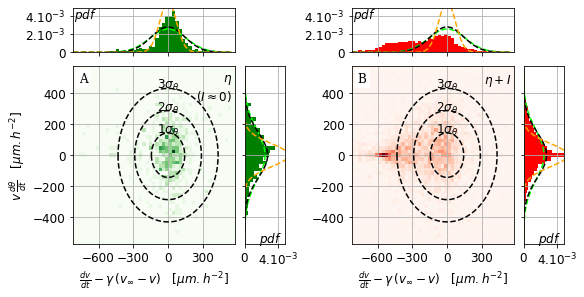

0.8593368913347436
M2WT_200616 [123.79378875067485, 139.25571929731166, 72.151140203773, 90.90500270635992, 100.59381243666135, 105.49140173477815, 5.072513050390715, 6.1207656245615745]


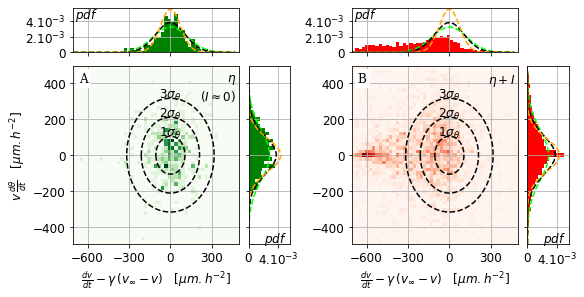

0.13021119787170973
M2WT_200617 [139.83927999917427, 150.32184084793698, 73.78976219369711, 70.87426105032645, 118.78592183455534, 132.56505933496456, 4.4476755885155645, 4.605267026657083]


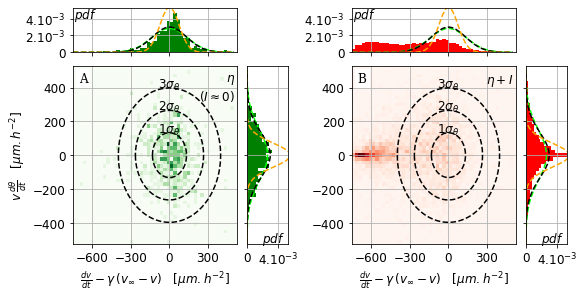

0.24325107807986365
M2WT_210304 [117.34944915279354, 128.653749640729, 69.89467171045384, 74.33411294299285, 94.26360953704224, 105.00584245458802, 4.307934830434832, 4.648175453530124]


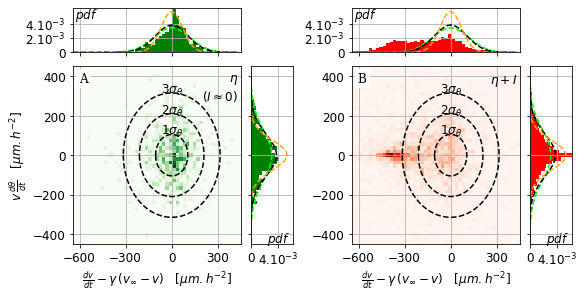

0.27210867762355906
M2WT_210909 [111.55779451705351, 125.84102398853834, 70.00769465094172, 75.19186355579701, 86.85657261928795, 100.90662502279167, 5.646173479615957, 6.184176450901451]


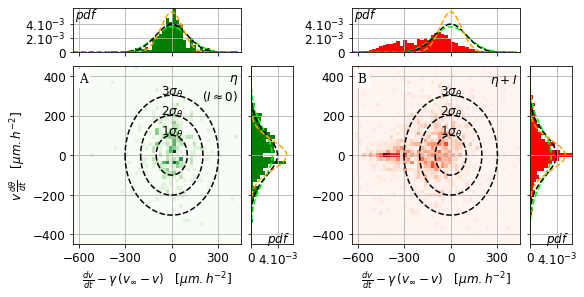

In [16]:
def deconvolution(samples:list,sigma_error:float):
    """ 
    Given a list of sample return the standard deviation
    of the distribution corrected by the numerical error estimated.
    """
    SIGMA = np.std(samples)
    N = len(samples)
    sigma_squared = max(SIGMA*SIGMA-sigma_error*sigma_error,0)
    sigma = np.sqrt(sigma_squared)
    dsigma = np.sqrt(SIGMA**4/(2*N*sigma_squared))
    return sigma,dsigma

def error_etas(dX:float,T:float,gamma:float,majoration:float):
    """ 
    Given the numerical error on the position, the temporal resolution T, the estimation of gamma
    and a majoration of the ratio eta_theta**2*T**2/(2*v**2), return the numerical error expected
    on the distribution of etas. 
    """
    commonFactor:float = 2*dX/(T*T)
    return (commonFactor*np.sqrt(1+gamma*gamma*T*T/2),commonFactor*np.sqrt(1+majoration))

def reseau2sigmas(reseauName:str):
    """ 
    Given the name of a reseau, return SIGMA_v,SIGMA_theta, eps_v, eps_theta, sigma_v, 
    sigma_theta, dsigma_v and dsigma_theta 
    """
    eta = etas[reseauName]
    data_f = datas_f[reseauName]
    SIGMA_v,SIGMA_theta = np.std(eta[0,:]),np.std(eta[1,:])
    dX = 3#\micro m
    T = 1*frame2h #h
    popt,covar = fit_witherror[reseauName]
    gamma = popt[0]
    majoration = np.max((eta[1,:]*eta[1,:]*T*T)/(2*data_f[:,1]*data_f[:,1]))
    print(majoration)
    eps_v,eps_theta = error_etas(dX,T,gamma,majoration)
    sigma_v,dsigma_v = deconvolution(eta[0,:],eps_v)
    sigma_theta,dsigma_theta = deconvolution(eta[1,:],eps_theta)
    return [SIGMA_v,SIGMA_theta,eps_v,eps_theta,sigma_v,sigma_theta,dsigma_v,dsigma_theta]

for rname,eta_free in etas.items():
    eta_ob = etas_obstr[rname]
    gamma,vinf,sigma = fit[rname]
    Npts = np.sum(np.logical_and(np.abs(eta_free[0,:])<4*sigma,
                                 np.abs(eta_free[1,:])<4*sigma))
    thetas = np.linspace(-np.pi,np.pi,360)
    fig_2, axs = plt.subplot_mosaic([['histx', '.','histx2','.'],
                                   ['scatter', 'histy','scatter2','histy2']],
                                figsize=(8,4),
                                gridspec_kw={'width_ratios':[4,1,4,1], 'height_ratios':[1,4]},
                                layout='constrained')
    axs["histy"].sharey(axs["scatter2"])
    bins_x = np.linspace(-5,3.5,50)*sigma
    bins_y = np.linspace(-3.5,3.5,50)*sigma
    bins= (bins_x,bins_y)
    #bins = 5*sigma*np.linspace(-1,1,50)
    scatter_hist(eta_free[0,:],eta_free[1,:],axs['scatter'],axs["histx"],axs['histy'],
                 bins=bins,color="green",cmap="Greens")
    scatter_hist(eta_ob[0,:],eta_ob[1,:],axs['scatter2'],axs["histx2"],axs['histy2'],
                 bins=bins,color="red",cmap="Reds")
    #scatter_hist(eta_ob[0,:],eta_ob[1,:],axs['scatter'],axs["histx"],axs['histy'],
    #             bins=bins,color="red")
    SIGMAS = reseau2sigmas(rname)
    print(rname,SIGMAS)
    for ax in (axs["scatter"],axs["scatter2"]):
        for i in range(1,4):
            sigma_theta = SIGMAS[5]
            ax.plot(i*sigma_theta*np.cos(thetas),i*sigma_theta*np.sin(thetas),'k--')
            ax.text(x=0,y=i*sigma_theta,s=f"${i}\sigma_\\theta$",horizontalalignment="center")
            ax.set_xlabel("$\\frac{dv}{dt} - \gamma\,(v_\infty-v)\quad[\mu m.h^{-2}]$")
            #ax.xaxis.set_label_coords(0.5,0.1)
            #ax.yaxis.set_label_coords(0.3,0.7)
            ax.set_xlim(bins_x[0],bins_x[-1])
            ax.set_ylim(bins_y[0],bins_y[-1])
            ax.set_xticks([-600,-300,0,300])
            ax.grid()
    ax = axs["scatter"]
    ax.set_ylabel("$v\,\\frac{d\\theta}{dt}\quad[\mu m.h^{-2}]$")
    ax.annotate(
        "A",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0))
    ax.annotate(
        "$\eta$\n$(I\\approx 0)$",
        xy=(0.95, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        horizontalalignment='right',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    ax = axs["scatter2"]
    ax.annotate(
        "B",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0))
    ax.annotate(
        "$\eta + I$",
        xy=(0.95, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        horizontalalignment='right',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    #axs['scatter2'].set_yticklabels([],visible=False)
    pdf_lim = np.sqrt(2/np.pi)/sigma
    for i_ax,ax in enumerate((axs["histx"],axs["histx2"])):
        SIGMA_v = SIGMAS[0]
        sigma_v = SIGMAS[4]
        eps_v = SIGMAS[2]
        xx = (bins_x[:-1]+bins_x[:-1])/2
        ax.plot(xx,norm.pdf(xx/SIGMA_v)/SIGMA_v,'--',color = "lime")
        ax.plot(xx,norm.pdf(xx/sigma_theta)/sigma_theta,'k--')
        ax.plot(xx,norm.pdf(xx/eps_v)/eps_v,ls='--',color="orange")
        ax.set_ylim(0,pdf_lim)
        ax.set_yticks([0,2e-3,4e-3],labels=["0","$2.10^{-3}$","$4.10^{-3}$"])
        ax.grid()
    for i_ax,ax in enumerate((axs['histy'],axs["histy2"])):
        SIGMA_theta = SIGMAS[1]
        sigma_theta = SIGMAS[5]
        eps_theta = SIGMAS[3]
        xx = (bins_y[:-1]+bins_y[:-1])/2
        ax.plot(norm.pdf(xx/SIGMA_theta)/SIGMA_theta,xx,'--',color ="lime")
        ax.plot(norm.pdf(xx/sigma_theta)/sigma_theta,xx,'k--')
        ax.plot(norm.pdf(xx/eps_theta)/eps_theta,xx,ls='--',color="orange")
        ax.set_xlim(0,pdf_lim)
        ax.set_xticks([0,4e-3],labels=["0","$4.10^{-3}$"])
        ax.grid()
    #fig_2.savefig(f"/Users/thibault/Documents/GitHub/Articles/ReportGrowthHyphae/NoiseInteraction_{rname}_cmap_horizontal_v2.jpg",dpi=300)
    plt.show()
    plt.close()


# Point $(-\gamma v_\infty,0)$

The over-representation of the point ($-\gamma v_\infty$ ,0) could simply be the result of branches that have stopped growing. We propose here to eliminate the branches that stop from the treatment in order to better isolate the signature of an interaction other than a simple stop.


/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:18: RuntimeWarning: divide by zero encountered in true_divide
  dthetadt = np.where(dt>0,(angles[2:]-angles[:-2])/(times[2:]-times[:-2]),0)
/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:20: RuntimeWarning: divide by zero encountered in true_divide
  dvdt = np.where(dt>0,(normes[2:]-normes[:-2])/(times[2:]-times[:-2]),0)


0.269073060462675


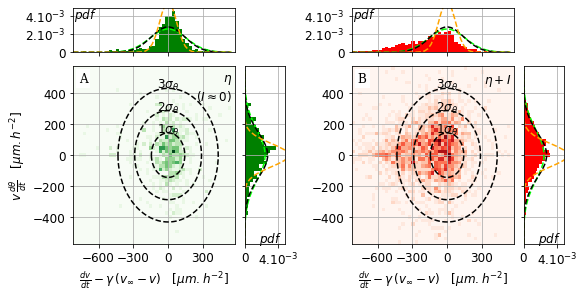

M2WT_200610
67	584	373	2279
1.819996176627544+/-0.18397930441757013
317.15853464926414+/-3.5304183564887457
162.53237839402686+/-6.7537340970052755
144.140380578281+/-5.362566556416666


/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:18: RuntimeWarning: divide by zero encountered in true_divide
  dthetadt = np.where(dt>0,(angles[2:]-angles[:-2])/(times[2:]-times[:-2]),0)
/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:20: RuntimeWarning: divide by zero encountered in true_divide
  dvdt = np.where(dt>0,(normes[2:]-normes[:-2])/(times[2:]-times[:-2]),0)


0.8593368913347436


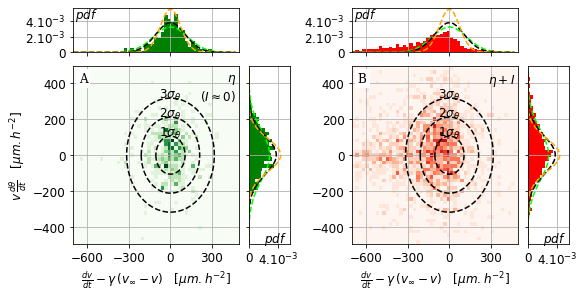

M2WT_200616
47	451	271	1879
1.95107994231408+/-0.1930300999391595
322.32029847875276+/-3.1632041599176697
139.25571929731166+/-8.328735665522114
105.49140173477815+/-6.1207656245615745


/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:18: RuntimeWarning: divide by zero encountered in true_divide
  dthetadt = np.where(dt>0,(angles[2:]-angles[:-2])/(times[2:]-times[:-2]),0)
/var/folders/f5/852xsj3n7994_yxp7x3rqskw0000gn/T/ipykernel_84203/544853854.py:20: RuntimeWarning: divide by zero encountered in true_divide
  dvdt = np.where(dt>0,(normes[2:]-normes[:-2])/(times[2:]-times[:-2]),0)


0.13021119787170973


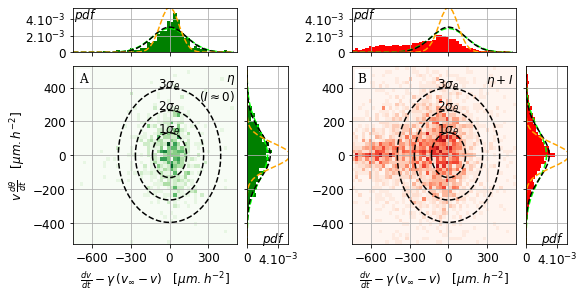

M2WT_200617
69	685	631	3715
2.2366096666136515+/-0.14873243163426236
322.9423060177977+/-2.2776812732194074
150.32184084793698+/-4.430085066028937
132.56505933496456+/-4.605267026657083
0.24325107807986365


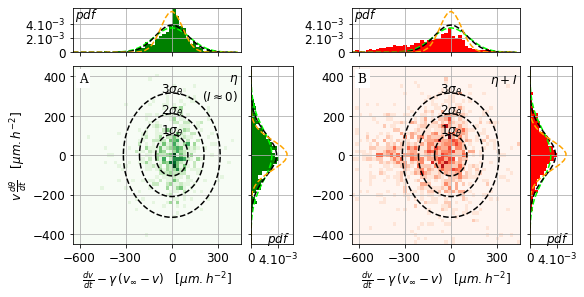

M2WT_210304
61	575	200	1395
1.4846223241411758+/-0.140355233976199
280.18817319772734+/-3.397401998708719
128.653749640729+/-5.490259823403674
105.00584245458802+/-4.648175453530124
0.27210867762355906


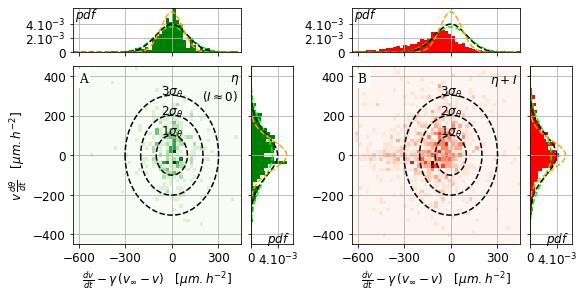

M2WT_210909
36	322	120	905
1.5110143379449574+/-0.21337159630069932
291.26668410672335+/-5.600794162028836
125.84102398853834+/-6.152670935166662
100.90662502279167+/-6.184176450901451


In [ ]:
def testifstop(b,seuil:float=2)->bool:
    """
    Test whether the branch stop at any point or not.
    A branch is considered stopped if it spend more than the seuil value time at the 
    same position.
    """
    dt = np.array(b.t)[1:]-np.array(b.t)[:-1]
    return np.all(dt <= seuil)

means= []
for r in M2s:
    rname = r.name
    eta_free = etas[rname]
    bi2b = {b.index:b for b in r.branches}
    data_obst = filtre_data(branches2growthdata(r,branches[r.name][1]))
    bi2keep = [bi for bi in np.unique(data_obst[:,-1]) if testifstop(bi2b[bi],seuil=1)]
    Nobst = len(bi2keep)
    filtre = np.array([bi in bi2keep for bi in data_obst[:,-1]])
    data_obst = data_obst[filtre,:]
    nobst = len(data_obst)
    #C'est à partir d'ici qu'il faut récupérer les bons comptes
    (gamma,vinf,sigma),covar = fit_witherror[rname]
    dgamma = np.sqrt(covar[0,0])
    dvinf = np.sqrt(covar[1,1])
    dSigma_theta = np.sqrt(covar[2,2])
    eta_ob = eta(data_obst,gamma,vinf)
    Npts = np.sum(np.logical_and(np.abs(eta_free[0,:])<4*sigma,
                                np.abs(eta_free[1,:])<4*sigma))
    thetas = np.linspace(-np.pi,np.pi,360)
    fig_2, axs = plt.subplot_mosaic([['histx', '.','histx2','.'],
                                    ['scatter', 'histy','scatter2','histy2']],
                                    figsize=(8,4),
                                    gridspec_kw={'width_ratios':[4,1,4,1], 'height_ratios':[1,4]},
                                    layout='constrained')
    axs["histy"].sharey(axs["scatter2"])
    bins_x = np.linspace(-5,3.5,50)*sigma
    bins_y = np.linspace(-3.5,3.5,50)*sigma
    bins= (bins_x,bins_y)
    scatter_hist(eta_free[0,:],eta_free[1,:],axs['scatter'],axs["histx"],axs['histy'],
                bins=bins,color="green",cmap="Greens")
    scatter_hist(eta_ob[0,:],eta_ob[1,:],axs['scatter2'],axs["histx2"],axs['histy2'],
                bins=bins,color="red",cmap="Reds")
    SIGMAS = reseau2sigmas(rname)
    for ax in (axs["scatter"],axs["scatter2"]):
        for i_ in range(1,4):
            sigma_theta = SIGMAS[5]
            ax.plot(i_*sigma_theta*np.cos(thetas),i_*sigma_theta*np.sin(thetas),'k--')
            ax.text(x=0,y=i_*sigma_theta,s=f"${i_}\sigma_\\theta$",horizontalalignment="center")
            ax.set_xlabel("$\\frac{dv}{dt} - \gamma\,(v_\infty-v)\quad[\mu m.h^{-2}]$")
            ax.set_xlim(bins_x[0],bins_x[-1])
            ax.set_ylim(bins_y[0],bins_y[-1])
            ax.set_xticks([-600,-300,0,300])
            ax.grid()
    ax = axs["scatter"]
    ax.set_ylabel("$v\,\\frac{d\\theta}{dt}\quad[\mu m.h^{-2}]$")
    ax.annotate(
        "A",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0))
    ax.annotate(
        "$\eta$\n$(I\\approx 0)$",
        xy=(0.95, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        horizontalalignment='right',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    ax = axs["scatter2"]
    ax.annotate(
        "B",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0))
    ax.annotate(
        "$\eta + I$",
        xy=(0.95, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        horizontalalignment='right',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    #axs['scatter2'].set_yticklabels([],visible=False)
    pdf_lim = np.sqrt(2/np.pi)/sigma
    for i_ax,ax in enumerate((axs["histx"],axs["histx2"])):
        SIGMA_v = SIGMAS[0]
        sigma_v = SIGMAS[4]
        eps_v = SIGMAS[2]
        xx = (bins_x[:-1]+bins_x[:-1])/2
        ax.plot(xx,norm.pdf(xx/SIGMA_v)/SIGMA_v,'--',color = "lime")
        ax.plot(xx,norm.pdf(xx/sigma_theta)/sigma_theta,'k--')
        ax.plot(xx,norm.pdf(xx/eps_v)/eps_v,ls='--',color="orange")
        ax.set_ylim(0,pdf_lim)
        ax.set_yticks([0,2e-3,4e-3],labels=["0","$2.10^{-3}$","$4.10^{-3}$"])
        ax.grid()
    for i_ax,ax in enumerate((axs['histy'],axs["histy2"])):
        SIGMA_theta = SIGMAS[1]
        sigma_theta = SIGMAS[5]
        eps_theta = SIGMAS[3]
        xx = (bins_y[:-1]+bins_y[:-1])/2
        ax.plot(norm.pdf(xx/SIGMA_theta)/SIGMA_theta,xx,'--',color ="lime")
        ax.plot(norm.pdf(xx/sigma_theta)/sigma_theta,xx,'k--')
        ax.plot(norm.pdf(xx/eps_theta)/eps_theta,xx,ls='--',color="orange")
        ax.set_xlim(0,pdf_lim)
        ax.set_xticks([0,4e-3],labels=["0","$4.10^{-3}$"])
        ax.grid()
    fig_2.savefig(f"/Users/thibault/Documents/GitHub/Articles/ReportGrowthHyphae/NoiseInteraction_{rname}_cmap_{i}_horizontal_v2.jpg",dpi=300)
    plt.show()
    plt.close()
    print(r.name)
    data_f= datas_f[r.name]
    Nfree = len(np.unique(data_f[:,-1]))
    nfree = len(data_f)
    print(f"{Nfree}\t{nfree}\t{Nobst}\t{nobst}")
    Sigma_theta = SIGMAS[1]
    dsigma_theta = SIGMAS[7]
    print(f"{gamma}+/-{dgamma}\n{vinf}+/-{dvinf}\n{Sigma_theta}+/-{dSigma_theta}\n{sigma_theta}+/-{dsigma_theta}")
    means.append([[gamma,dgamma],[vinf,dvinf],[Sigma_theta,dSigma_theta],[sigma_theta,dsigma_theta]])
means = np.array(means)

In [20]:
sd = means[:,:,1]
mean = np.mean(means,axis=0)[:,0]
sd = np.std(means,axis=0)[:,0]
print(mean,sd)

[  1.80066449 306.77519929 141.32094243 117.62186183] [ 0.28171851 17.65345916 13.67692935 17.39104446]
